In [1]:
import torch
import torch.optim as optim
import torch.utils.data as Data
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

from EEG_cnn.model import *
from EEG_cnn.utils import *
from EEG_cnn.data_input import *

ModuleNotFoundError: No module named 'EEG_cnn'

### Loading 

In [2]:
combin_num = 20
train_num = 3000
test_num = 400

In [3]:
EEG = np.load('EEG_cnn/denoiseNET_dataset/EEG_artifacts.npy')
EOG = np.load('EEG_cnn/denoiseNET_dataset/EOG_artifacts.npy')
EMG = np.load('EEG_cnn/denoiseNET_dataset/EMG_artifacts.npy')

train_x_eog, train_y_eog, test_x_eog, test_y_eog, test_std_VALUE = data_prepare(EEG, EOG, combin_num, train_num, test_num)
train_x_emg, train_y_emg, test_x_emg, test_y_emg, test_std_VALUE = data_prepare(EEG, EMG, combin_num, train_num, test_num)

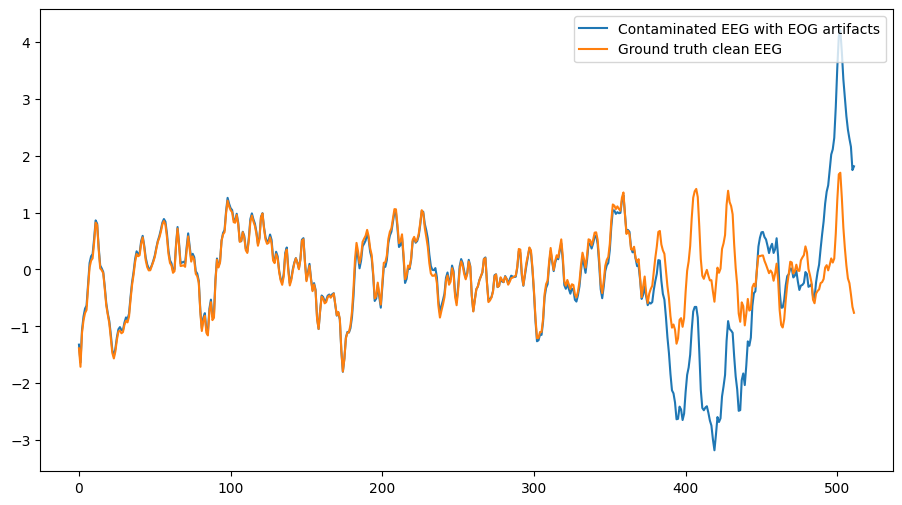

In [4]:
plt.figure(figsize=(11,6))
x1, = plt.plot(train_x_eog[0])
x2, = plt.plot(train_y_eog[0])
plt.legend([x1, x2], ['Contaminated EEG with EOG artifacts', 'Ground truth clean EEG'], loc='upper right')

### translating signals to images

In [5]:
from math import floor
import numpy as np
from skimage import color
import pandas as pd
import matplotlib.pyplot as plt

def sig_to_img(signal):
    img = np.zeros((len(signal),len(signal)))
    for i in range(len(signal)):
        for j in range(len(signal)):
            img[i][j] = floor((signal[i] + signal[j])*128)
    return img


def img_to_sig(img):
    signal = []
    for i in range(len(img)):
            signal.append(img[i][i] / 255)
    return signal

(-25.55, 536.55, -3.5478459936621296, 4.574867757101014)

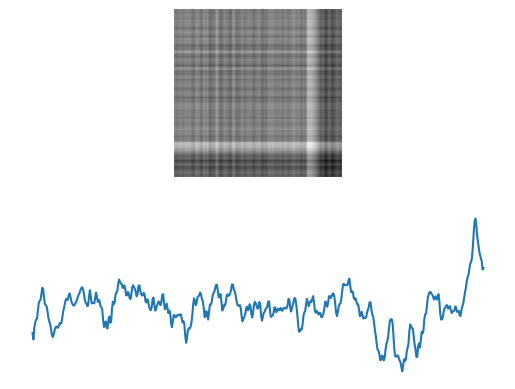

In [6]:
image = sig_to_img(train_x_eog[3])
fig, axs = plt.subplots(2)
axs[0].imshow(image, cmap = 'gray')
axs[0].axis('off')
axs[1].plot(train_x_eog[0])
plt.axis('off')

(-25.55, 536.55, -1.968029429235304, 1.875595908499248)

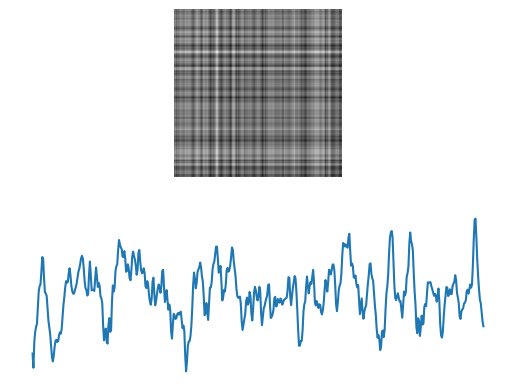

In [7]:
image1 = sig_to_img(train_y_eog[3])
fig, axs = plt.subplots(2)
axs[0].imshow(image1, cmap = 'gray')
axs[0].axis('off')
axs[1].plot(train_y_eog[0])
plt.axis('off')

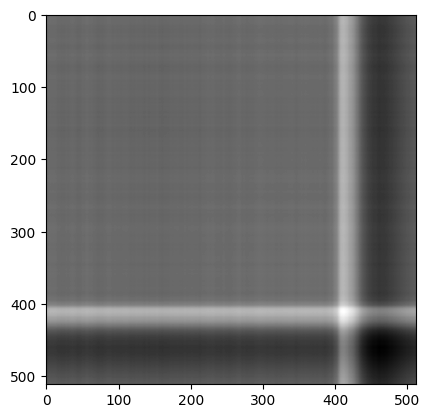

In [8]:
plt.imshow(image-image1, cmap='gray')

In [19]:
train_x_eog[0].shape

(512,)

### EOG first


we translate signals to images

In [10]:
import os
train_path = 'cycle_gan/EEG_cyclegan_dataset/test'
def translate_dataset(noisyframe, cleanframe):
    for i in range(2000,2125):
        for j in range(2):
            window = noisyframe[i][j*256:(j+1)*256]
            image = sig_to_img(window)
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            plt.savefig(os.path.join(train_path+'/A', 'EOG+EEG' + str(i) +'.png'), bbox_inches='tight', pad_inches = 0)
            plt.close()
            
            window = cleanframe[i][j*256:(j+1)*256]
            image = sig_to_img(window)
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            plt.savefig(os.path.join(train_path+'/B', 'EEG' + str(i) +'.png'), bbox_inches='tight', pad_inches = 0)
            plt.close()
translate_dataset(train_x_eog, train_y_eog)

In [1]:
from cycle_gan.models import Discriminator
from cycle_gan.models import Generator
from cycle_gan.utils import ReplayBuffer
from cycle_gan.utils import LambdaLR
from cycle_gan.utils import Logger
from cycle_gan.utils import weights_init_normal
import torch

In [2]:
netG_A2B = Generator(1, 1)
netG_B2A = Generator(1,1)
netD_A = Discriminator(1)
netD_B = Discriminator(1)

netG_A2B.cuda()
netG_B2A.cuda()
netD_A.cuda()
netD_B.cuda()

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [3]:
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)


Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [4]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [5]:
import itertools
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=0.0001, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(200, 0, 100).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(200, 0, 100).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(200, 0, 100).step)

In [6]:
#run this cell everytime that we need to continue the training from a previous run
# loading the models
netD_A.load_state_dict(torch.load('output/netD_A.pth'))
netD_B.load_state_dict(torch.load('output/netD_B.pth'))
netG_A2B.load_state_dict(torch.load('output/netG_A2B.pth'))
netG_B2A.load_state_dict(torch.load('output/netG_B2A.pth'))

# loading optimizers
optimizer_D_A.load_state_dict(torch.load('output/optimizer_D_A.pth'))
optimizer_D_B.load_state_dict(torch.load('output/optimizer_D_B.pth'))
optimizer_G.load_state_dict(torch.load('output/optimizer_G.pth'))

# loading schedulers
lr_scheduler_D_A.load_state_dict(torch.load('output/lr_scheduler_D_A.pth'))
lr_scheduler_D_B.load_state_dict(torch.load('output/lr_scheduler_D_B.pth'))
lr_scheduler_G.load_state_dict(torch.load('output/lr_scheduler_G.pth'))

# Mover os modelos para a GPU, se disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
netD_A.to(device)
netD_B.to(device)
netG_A2B.to(device)
netG_B2A.to(device)

# adapting the optimizers to rhe right device
for state in optimizer_D_A.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

for state in optimizer_D_B.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

for state in optimizer_G.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

In [7]:
batch_size = 5
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader


Tensor = torch.cuda.FloatTensor
input_A = Tensor(batch_size, 1, 256, 256)
input_B = Tensor(batch_size, 1, 256, 256)
target_real = Variable(Tensor(batch_size).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batch_size).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [8]:
class ConvertToSingleChannel(object):
    def __call__(self, tensor):
        if tensor.dim() != 1  and tensor.size(0) > 1:
            #ignoring the the last dimension from what we saw yesterday
            tensor = torch.mean(tensor[:3, :, : ], dim=0, keepdim=True)
            #tensor = tensor[0, :, : ].unsqueeze(0)
        return tensor

In [9]:
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from cycle_gan.datasets import ImageDataset

transforms_ = [ transforms.Resize(int(256*1.12), Image.BICUBIC),
                transforms.RandomCrop(256), 
                transforms.ToTensor(),
                ConvertToSingleChannel(),
                transforms.Normalize((0.5), (0.5))
               ]
dataloader = DataLoader(ImageDataset('EEG_cyclegan_dataset/', transforms_ = transforms_, unaligned=True), 
                        batch_size=batch_size, shuffle=True, num_workers=4)


/home/filhoij/miniconda3/envs/research-dl1/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
import gc
torch.cuda.empty_cache()
gc.collect()

50

In [18]:
epochs = 50
logger = Logger(epochs, len(dataloader))

Setting up a new session...


In [19]:
for epoch in range(1, epochs + 1):
    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################

        # Progress report (http://localhost:8097)
        logger.log({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
                    'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)}, 
                    images={'real_A': real_A, 'real_B': real_B, 'fake_A': fake_A, 'fake_B': fake_B})
    
    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Save models checkpoints
    torch.save(netG_A2B.state_dict(), 'output/netG_A2B.pth')
    torch.save(netG_B2A.state_dict(), 'output/netG_B2A.pth')
    torch.save(netD_A.state_dict(), 'output/netD_A.pth')
    torch.save(netD_B.state_dict(), 'output/netD_B.pth')

Epoch 001/050 [0315/0315] -- loss_G: 3.3214 | loss_G_identity: 0.4630 | loss_G_GAN: 1.8783 | loss_G_cycle: 0.9801 | loss_D: 0.0361 -- ETA: 3:36:24.0142533
Epoch 003/050 [0315/0315] -- loss_G: 3.3113 | loss_G_identity: 0.4664 | loss_G_GAN: 1.8623 | loss_G_cycle: 0.9827 | loss_D: 0.0406 -- ETA: 3:27:06.296642
Epoch 004/050 [0315/0315] -- loss_G: 3.1411 | loss_G_identity: 0.4648 | loss_G_GAN: 1.7161 | loss_G_cycle: 0.9602 | loss_D: 0.1002 -- ETA: 3:23:05.553568
Epoch 005/050 [0315/0315] -- loss_G: 3.2828 | loss_G_identity: 0.4649 | loss_G_GAN: 1.8489 | loss_G_cycle: 0.9689 | loss_D: 0.0394 -- ETA: 3:18:30.314215
Epoch 006/050 [0315/0315] -- loss_G: 3.3023 | loss_G_identity: 0.4688 | loss_G_GAN: 1.8547 | loss_G_cycle: 0.9788 | loss_D: 0.0458 -- ETA: 3:13:58.846657
Epoch 007/050 [0315/0315] -- loss_G: 3.2722 | loss_G_identity: 0.4627 | loss_G_GAN: 1.8429 | loss_G_cycle: 0.9666 | loss_D: 0.0452 -- ETA: 3:09:31.573535
Epoch 008/050 [0315/0315] -- loss_G: 3.2728 | loss_G_identity: 0.4625 | los

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 018/050 [0315/0315] -- loss_G: 3.2277 | loss_G_identity: 0.4465 | loss_G_GAN: 1.8490 | loss_G_cycle: 0.9322 | loss_D: 0.0439 -- ETA: 2:20:55.055238
Epoch 019/050 [0315/0315] -- loss_G: 3.2327 | loss_G_identity: 0.4453 | loss_G_GAN: 1.8520 | loss_G_cycle: 0.9353 | loss_D: 0.0412 -- ETA: 2:16:30.227774
Epoch 020/050 [0315/0315] -- loss_G: 3.1065 | loss_G_identity: 0.4292 | loss_G_GAN: 1.7987 | loss_G_cycle: 0.8786 | loss_D: 0.0543 -- ETA: 2:12:06.504016
Epoch 021/050 [0315/0315] -- loss_G: 3.1625 | loss_G_identity: 0.4269 | loss_G_GAN: 1.8473 | loss_G_cycle: 0.8883 | loss_D: 0.0429 -- ETA: 2:07:41.653186
Epoch 022/050 [0315/0315] -- loss_G: 3.1445 | loss_G_identity: 0.4390 | loss_G_GAN: 1.8140 | loss_G_cycle: 0.8916 | loss_D: 0.0483 -- ETA: 2:03:17.777797
Epoch 023/050 [0315/0315] -- loss_G: 3.1007 | loss_G_identity: 0.4241 | loss_G_GAN: 1.8013 | loss_G_cycle: 0.8754 | loss_D: 0.0539 -- ETA: 1:58:53.484514
Epoch 024/050 [0315/0315] -- loss_G: 3.1474 | loss_G_identity: 0.4363 | loss

In [58]:
batch['A'][:, 0, :, :].view(batch_size, 1, 256, 256).shape

torch.Size([6, 1, 256, 256])

In [20]:
torch.save(optimizer_G.state_dict(), 'output/optimizer_G.pth')
torch.save(optimizer_D_A.state_dict(), 'output/optimizer_D_A.pth')
torch.save(optimizer_D_B.state_dict(), 'output/optimizer_D_B.pth')

#learningrateschedulers

torch.save(lr_scheduler_G.state_dict(), 'output/lr_scheduler_G.pth')
torch.save(lr_scheduler_D_A.state_dict(), 'output/lr_scheduler_D_A.pth')
torch.save(lr_scheduler_D_B.state_dict(), 'output/lr_scheduler_D_B.pth')

In [ ]:
optimizer_G.load_state_dict(torch.load('output/optimizer_G.pth'))
optimizer_D_A.load_state_dict(torch.load('output/optimizer_D_A.pth'))
optimizer_D_B.load_state_dict(torch.load('output/optimizer_D_B.pth'))

#learningrateschedulers

lr_scheduler_G.load_state_dict(torch.load('output/lr_scheduler_G.pth'))
lr_scheduler_D_A.load_state_dict(torch.load('output/lr_scheduler_D_A.pth'))
lr_scheduler_D_B.load_state_dict(torch.load('output/lr_scheduler_D_B.pth'))

In [78]:
logger.windows

AttributeError: 'Logger' object has no attribute 'windows'